In [1]:
import numpy as np
import scipy as sp
import json
from PIL import Image
from matplotlib import pyplot as plt
from scipy.misc import imresize

In [2]:
TRAIN_PATH = 'data/train/'
TRAIN_DIGITSTRUCT = 'data/train_ds.json'
DIGIT_RATIO = 24./32

In [3]:
with open(TRAIN_DIGITSTRUCT, 'r') as f:
    train_ds = json.load(f)
print(len(train_ds))

33402


In [4]:
sample = train_ds[44]
sample

{'filename': '45.png',
 'boxes': [{'height': 31.0,
   'label': 1.0,
   'left': 35.0,
   'top': 3.0,
   'width': 8.0},
  {'height': 31.0, 'label': 10.0, 'left': 44.0, 'top': 4.0, 'width': 12.0}]}

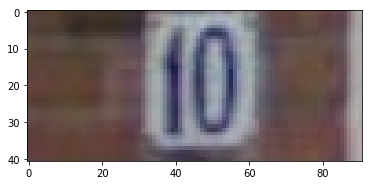

In [5]:
im = np.array(Image.open(TRAIN_PATH + sample['filename']))
plt.imshow(im)

In [6]:
def preprocess(img):
    try:
        img = imresize(img, (32, 24))
        img = img.astype(np.float32) / np.max(img)
    except:
        return None
    return img

def gen_cuts(image, boxes):
    cuts = []
    labels = []
    
    number_left = image.shape[1]
    number_right = 0
    number_top = image.shape[0]
    number_bottom = 0
    
    na_w = 0
    na_h = 0
    
    for box in boxes:
        middle = int(box['left'] + box['width'] / 2)
        height = int(box['height'])
        width = int(height * DIGIT_RATIO)
        left = int(middle - width/2)
        right = left + width
        top = int(box['top'])
        bottom = top + height
        
        if left < number_left: number_left = left
        if right > number_right: number_right = right
        if top < number_top: number_top = top
        if bottom > number_bottom: number_bottom = bottom
        if na_w == 0: na_w = width
        if na_h == 0: na_h = height
        
        cut = im[top:bottom, left:right]
        cut = preprocess(cut)
        
        if cut is None:
            continue
        
        cuts.append(cut)
        label = box['label'] if box['label'] != 10 else 0
        labels.append(int(label))
    
    for left in range(0, image.shape[1]-na_w, na_w):
        if (left+na_w < number_left) or (left > number_right):
            cut = im[0:na_h, left:left+na_w]
            cut = preprocess(cut)

            if cut is None:
                continue
            cuts.append(cut)
            labels.append(10)
    

    return cuts, labels

all_cuts = []
all_labels = []
for i, sample in enumerate(train_ds):
    if i % 1000 == 0: print(i)
    im = np.array(Image.open(TRAIN_PATH + sample['filename']).convert('L'))
    img_cuts, img_labels = gen_cuts(im, sample['boxes'])
    all_cuts.extend(img_cuts)
    all_labels.extend(img_labels)

print("{} cuts total".format(len(all_labels)))
print('done!')
    

0


/home/max/anaconda3/envs/cv_proj/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
136157 cuts total
done!


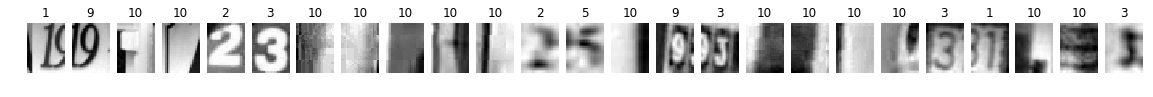

In [7]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=25)

for i, cut in enumerate(all_cuts[:25]):
    ax[i].axis('off')
    ax[i].imshow(cut, cmap='gray')
    ax[i].set_title(all_labels[i], loc='center')

In [8]:
X = np.array(all_cuts)
y = np.array([all_labels]).T
X.shape, y.shape

((136157, 32, 24), (136157, 1))

In [9]:
X.dump('X.p')
y.dump('y.p')

In [10]:
y_loaded = np.load('y.p')
y_loaded

array([[ 1],
       [ 9],
       [10],
       ...,
       [ 9],
       [10],
       [10]])

In [11]:
np.min(y_loaded)

0